# House Prices 房价预测分析
**数据来源**: Kaggle竞赛 [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

## 分析目标
1. 数据探索与清洗
2. 特征工程处理
3. 构建回归模型
4. 模型优化与验证

In [1]:
import os
import pandas as pd
import torch

# from src import utils  # 项目工具模块

# 数据路径配置
RAW_DATA = os.path.join('..', 'data', 'raw', 'house-prices-advanced-regression-techniques')

# 使用 pandas 读取数据
train_df = pd.read_csv(os.path.join(RAW_DATA, 'train.csv'))
test_df = pd.read_csv(os.path.join(RAW_DATA, 'test.csv'))

# 打印数据信息
print(train_df.shape)
print(test_df.shape)

# 打印0-4行,0,1,2,3,最后3列
print(train_df.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

print(test_df.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])


(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [2]:
print(train_df.head())
print(test_df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [3]:
all_features = pd.concat((train_df.iloc [:, 1:-1], test_df.iloc [:, 1:]))
print(all_features.shape)

(2919, 79)


In [4]:
# 数据预处理：数值型特征的标准化与缺失值处理

# 步骤1：筛选出所有数值型特征（非字符串/对象类型）
numeric_cols = all_features.dtypes[all_features.dtypes != 'object'].index

# 或者：
numeric_cols = all_features.select_dtypes(exclude=['object']).columns

# 步骤2：标准化处理（Z-score标准化）
# 原理：(当前值 - 特征平均值) / 特征标准差 → 使数据均值为0，标准差为1
all_features[numeric_cols] = all_features[numeric_cols].apply(
    lambda col: (col - col.mean()) / col.std()
)

# 步骤3：处理缺失值
# 注意：标准化后均值变为0，所以用0填充相当于用原特征均值填充
all_features[numeric_cols] = all_features[numeric_cols].fillna(0)

# 补充说明：这样处理后：
# - 所有数值特征都处于相似量纲
# - 缺失值被替换为该特征原始平均值对应的标准值(0)

以下是代码中用到的关键API的详细解释，按照代码执行顺序组织：

---

### 1. `pandas.DataFrame.select_dtypes()`
```python
numeric_cols = all_features.select_dtypes(exclude=['object']).columns
```
**作用**：  
根据数据类型筛选列

**参数说明**：
- `include`：要包含的数据类型列表
- `exclude`：要排除的数据类型列表（这里排除了`object`类型，即非数值型）

**返回值**：  
返回一个包含符合条件的列的`Index`对象

**等价写法**：  
你原来的写法 `all_features.dtypes[all_features.dtypes != 'object'].index` 也能实现相同效果，但`select_dtypes`更直观

---

### 2. `pandas.DataFrame.apply()`
```python
.apply(lambda col: (col - col.mean()) / col.std())
```
**作用**：  
对DataFrame的每一列应用函数

**参数说明**：
- 接受一个函数（这里用了lambda匿名函数）
- `lambda col:` 表示对每个列Series进行操作

**函数内部计算**：
- `col.mean()`：计算该列的算术平均值
- `col.std()`：计算该列的标准差
- `(x - mean)/std`：经典的Z-score标准化公式

---

### 3. `pandas.Series.fillna()`
```python
.fillna(0)
```
**作用**：  
填充缺失值（NaN值）

**参数说明**：
- `value`：填充值（这里用0）
- 其他可选参数：`method`（填充方法）、`limit`（填充数量限制）等

**特别说明**：  
在标准化后填充0的数学意义：
- 标准化后：均值=0 → 用0填充 = 用原特征均值填充
- 如果先填充再标准化，会扭曲原始分布

---

### 4. 补充：涉及的统计方法
- **`mean()`**：计算平均值  
  `col.mean()` = (所有值之和) / (非空值数量)

- **`std()`**：计算标准差  
  公式：$\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2}$  
  （默认计算样本标准差，分母为N）

---

### 执行流程总结：
1. **筛选列** → 2. **逐列标准化** → 3. **填充缺失值**  
每个步骤都返回新的DataFrame，通过链式操作完成全部转换

需要特别注意的操作顺序对结果的影响（先标准化再填充）！

`pandas.DataFrame.apply()` 与 JavaScript 中的 `Array.prototype.map()` 或 `Array.prototype.forEach()` 非常相似，都是**高阶函数**（Higher-Order Function），即可以接受其他函数作为参数的函数。以下是具体对比：

---

### 1. 最相似的 JS 高阶函数：`Array.prototype.map()`
#### 相似点：
| 特性                | `pandas.apply()`               | `JS array.map()`               |
|---------------------|--------------------------------|--------------------------------|
| **作用**            | 对每个元素/列应用函数          | 对每个数组元素应用函数         |
| **返回值**          | 返回处理后的新对象（不修改原对象） | 返回新数组（不修改原数组）     |
| **函数参数**        | 接受一个函数作为参数           | 接受一个回调函数作为参数       |
| **典型用途**        | 数据转换/标准化                | 数组元素转换                   |

#### 示例对比：
```python
# Python pandas
df.apply(lambda x: x * 2)  # 所有列的值乘以2
```
```javascript
// JavaScript
array.map(x => x * 2);  // 所有数组元素乘以2
```

---

### 2. 与其他 JS 高阶函数的关联
| JS 函数            | 相似点                         | 差异点                         |
|--------------------|-------------------------------|-------------------------------|
| `Array.forEach()`  | 遍历元素                       | `forEach` 无返回值（仅副作用） |
| `Array.reduce()`   | 可实现聚合操作（如求和）       | `apply` 更侧重元素级转换       |
| `Array.filter()`   | 无直接对应，但可用布尔索引实现 | pandas 有专门的 `query()`/布尔索引 |

---

### 3. 关键区别：**轴向控制**
`pandas.apply()` 的独特之处在于可以通过 `axis` 参数控制操作方向：
```python
df.apply(func, axis=0)  # 默认：对每列应用（类似 JS 的列式操作）
df.apply(func, axis=1)  # 对每行应用（无直接对应的 JS 实现）
```
这在 JavaScript 的数组方法中没有直接等价物。

---

### 4. 为什么设计成这样？
- **函数式编程思想**：两者都借鉴了函数式编程中"操作数据而不修改原数据"的理念
- **数据批处理需求**：适合对结构化数据/数组进行批量操作
- **API 一致性**：`pandas` 的设计者明显参考了 JavaScript/R 等语言的高阶函数模式

---

### 实际应用建议：
如果你熟悉 JS 的 `map`，可以这样理解：
```python
# pandas 的 apply 相当于：
df.columns.map(col => func(df[col]))  # 伪代码
```
但 `pandas` 的版本经过高度优化，处理大数据时效率更高。

## 不同版本的标准化处理

### **基础功能实现 vs. 高级实现对比**
让我们拆解这段代码，先给出一个**基础版本**（手动实现标准化），再对比 **Pandas 高级版本** 的区别和优化点。

---

## **1. 基础功能实现版本**
假设 `all_features` 是一个 `DataFrame`，`numeric_cols` 是需要标准化的数值列。我们可以用 Python 原生方式实现标准化：

```python
# 基础实现：手动标准化每一列
for col in numeric_cols:
    column_data = all_features[col]
    
    # 计算均值和标准差
    mean = sum(column_data) / len(column_data)
    std_dev = (sum((x - mean) ** 2 for x in column_data) / len(column_data)) ** 0.5
    
    # 标准化：Z = (X - μ) / σ
    standardized_column = [(x - mean) / std_dev for x in column_data]
    
    # 更新列
    all_features[col] = standardized_column
```

### **基础版本的缺点**
1. **循环效率低**：Python 的 `for` 循环在 Pandas 中较慢，尤其是大数据集。
2. **未处理缺失值（NaN）**：如果列中有 `NaN`，计算 `mean` 和 `std` 会出错。
3. **代码冗长**：需要手动计算统计量，并逐元素处理。

---

## **2. Pandas 高级版本**
```python
all_features[numeric_cols] = all_features[numeric_cols].apply(
    lambda col: (col - col.mean()) / col.std()
)
```

### **高级版本的优势**
| 特性 | 基础版本 | Pandas 高级版本 |
|------|---------|----------------|
| **计算方式** | 手动循环计算 | 向量化计算（底层用 NumPy 优化） |
| **缺失值处理** | 会报错（需额外处理） | 自动跳过 NaN 计算（`mean()` 和 `std()` 默认忽略 NaN） |
| **代码简洁性** | 冗长（需手动计算统计量） | 一行搞定（`apply` + `lambda`） |
| **执行速度** | 慢（Python 循环） | 快（C 优化的底层实现） |
| **适用性** | 仅适用于单列 | 可同时处理多列（`apply` 自动逐列计算） |

---

## **3. 高级版本底层发生了什么？**
### **(1) `all_features[numeric_cols]`**
- 仅选择数值列，避免对非数值列（如字符串）进行无效操作。

### **(2) `.apply(lambda col: ...)`**
- `apply` 会对 `DataFrame` 的**每一列**执行给定的函数（`lambda`）。
- **自动向量化计算**：`col - col.mean()` 不是逐元素计算，而是**整列广播运算**（类似 NumPy 的向量化操作）。
- **自动跳过 NaN**：`col.mean()` 和 `col.std()` 默认忽略缺失值（`skipna=True`）。

### **(3) `(col - col.mean()) / col.std()`**
- **`col.mean()`**：计算列的均值（自动忽略 NaN）。
- **`col.std()`**：计算列的标准差（自动忽略 NaN）。
- **标准化公式**：`(X - μ) / σ`，使数据均值为 0，标准差为 1。

---

## **4. 差异总结**
| 对比项 | 基础版本 | Pandas 高级版本 |
|--------|---------|----------------|
| **计算方式** | `for` 循环 + 逐元素计算 | 向量化运算（`apply` + 广播机制） |
| **缺失值处理** | 需手动处理 | 自动跳过 NaN |
| **代码量** | 多（需手动计算统计量） | 少（一行搞定） |
| **性能** | 慢（Python 循环） | 快（底层 C 优化） |
| **适用场景** | 学习/调试 | 生产环境/大数据 |

---

## **5. 进阶优化（更快的替代方案）**
如果数据量极大，`apply` 仍然可能较慢，可以使用 **`scikit-learn` 的 `StandardScaler`** 或 **`pandas` 内置方法** 进一步优化：
```python
# 方法1：用 pandas 内置方法（更快）
all_features[numeric_cols] = (
    all_features[numeric_cols] - all_features[numeric_cols].mean()
) / all_features[numeric_cols].std()

# 方法2：用 scikit-learn（适合机器学习流水线）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_features[numeric_cols] = scaler.fit_transform(all_features[numeric_cols])
```

---

## **总结**
- **基础版本**：适合理解原理，但效率低、代码冗长。
- **Pandas 高级版本**：利用 `apply` + `lambda` 实现向量化计算，自动处理 NaN，代码简洁高效。
- **生产推荐**：超大数据集可用 `scikit-learn` 的 `StandardScaler` 进一步优化。

这样，你既理解了底层逻辑，又学会了如何用 Pandas 高效实现！ 🚀

### 处理离散值


In [5]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

与李沐不同可能由于pandas版本不同

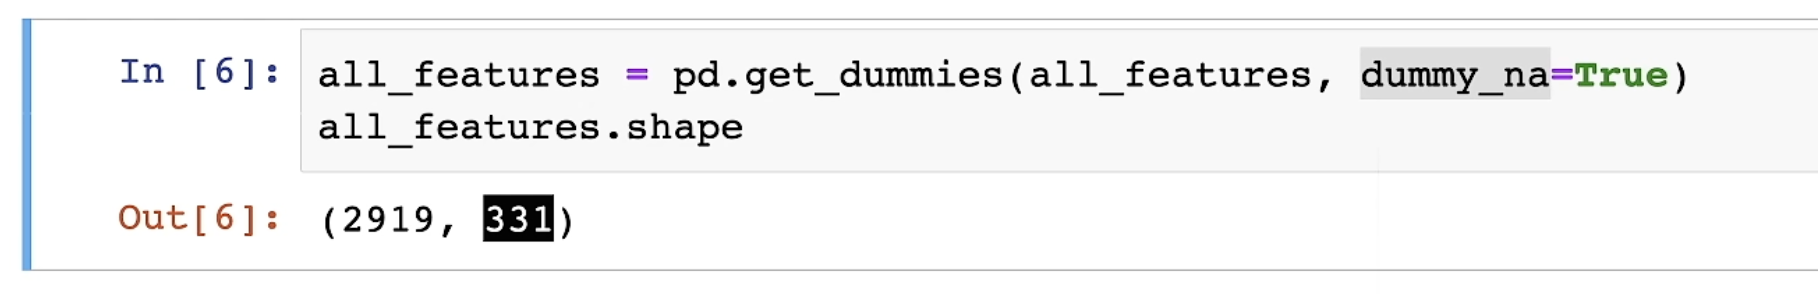

In [6]:
n_train = train_df.shape[0]
# 解决下面dtype报错,将true和false转换为1和0
# all_features = all_features * 1.0
all_features = all_features.astype(float)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_df.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

这段代码主要完成数据预处理，将Pandas DataFrame转换为PyTorch Tensor，为训练机器学习模型做准备。下面我会逐步解释每一行代码的作用：

---

### **1. `n_train = train_df.shape[0]`**
- **作用**：获取训练集的样本数量
- **解释**：
  - `train_df.shape` 返回DataFrame的维度 `(行数, 列数)`
  - `[0]` 取第一个元素，即行数（样本数量）
- **示例**：
  ```python
  train_df = pd.DataFrame({'A': [1,2,3], 'B': [4,5,6]})
  n_train = train_df.shape[0]  # 返回3
  ```

---

### **2. `all_features = all_features * 1.0`**
- **作用**：将布尔值(`True/False`)转换为浮点数(`1.0/0.0`)
- **解释**：
  - Pandas生成的独热编码(dummy variables)默认是`bool`或`uint8`类型
  - 乘以`1.0`会触发类型转换(`bool` → `float`)
- **替代写法**：
  ```python
  all_features = all_features.astype(float)
  ```

---

### **3. `train_features = torch.tensor(...)`**
```python
train_features = torch.tensor(
    all_features[:n_train].values,  # 取前n_train行作为训练特征
    dtype=torch.float32            # 指定为32位浮点数
)
```
- **作用**：将训练特征转换为PyTorch Tensor
- **关键点**：
  - `all_features[:n_train]`：切片操作，取前`n_train`行（训练集）
  - `.values`：将Pandas DataFrame转换为NumPy数组
  - `dtype=torch.float32`：神经网络通常使用32位浮点数

---

### **4. `test_features = torch.tensor(...)`**
```python
test_features = torch.tensor(
    all_features[n_train:].values,  # 取n_train行之后的数据作为测试集
    dtype=torch.float32
)
```
- **作用**：将测试特征转换为PyTorch Tensor
- **注意**：
  - 这里假设`all_features`包含训练和测试数据，且训练数据在前

---

### **5. `train_labels = torch.tensor(...)`**
```python
train_labels = torch.tensor(
    train_df.SalePrice.values.reshape(-1, 1),  # 获取标签并调整形状
    dtype=torch.float32
)
```
- **作用**：将目标变量（房价）转换为PyTorch Tensor
- **关键点**：
  - `SalePrice.values`：获取房价列的NumPy数组
  - `.reshape(-1, 1)`：将一维数组转为二维（`[n_samples, 1]`），符合PyTorch的格式要求
  - 例如：`[1,2,3]` → `[[1],[2],[3]]`

---

### **完整流程总结**
1. **确定训练集大小**：`n_train = train_df.shape[0]`
2. **数据类型转换**：布尔值 → 浮点数 (`* 1.0`)
3. **特征分割**：
   - 训练特征：`all_features[:n_train]`
   - 测试特征：`all_features[n_train:]`
4. **转换为PyTorch Tensor**：
   - 特征：`torch.tensor(..., dtype=torch.float32)`
   - 标签：额外做`reshape(-1, 1)`保证正确形状

---

### **为什么需要这些操作？**
| 操作 | 目的 |
|------|------|
| 类型转换 | 神经网络只能处理数值数据 |
| 形状调整 | 确保标签与模型输出维度匹配 |
| Tensor转换 | PyTorch模型要求输入为Tensor |

---

### **常见问题**
**Q1: 为什么不直接用`torch.from_numpy()`?**  
A: `torch.tensor()`更通用，会自动复制数据，而`from_numpy()`共享内存。

**Q2: 为什么要`reshape(-1, 1)`?**  
A: 使标签形状从`(n_samples,)`变为`(n_samples, 1)`，与模型输出形状一致。

训练

In [7]:
# 均方误差损失函数
loss = torch.nn.MSELoss()
# shape:(样本数, 特征数)
in_features = train_features.shape[1]

def get_net():
    # 定义网络结构
    # Sequential是PyTorch中用于构建神经网络的模块，它可以将多个层组合成一个网络
    # Linear是PyTorch中用于构建线性层的模块，它接收输入特征，输出线性变换后的结果
    net = torch.nn.Sequential(torch.nn.Linear(in_features, 1))
    return net

这段代码定义了一个**均方误差损失函数**和一个简单的**线性回归神经网络模型**。下面我会详细解释每一部分的作用和原理：

---

### **1. 定义损失函数**
```python
loss = torch.nn.MSELoss()
```
- **作用**：创建均方误差（Mean Squared Error, MSE）损失函数
- **数学公式**：
  $
  \text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2
  $
  其中 $ y_i $ 是真实值，$ \hat{y}_i $ 是预测值
- **特点**：
  - 常用于回归问题（如房价预测）
  - 对离群值敏感（因为平方放大了大误差的影响）
- **调用方式**：
  ```python
  output = model(inputs)
  mse_loss = loss(output, targets)  # 计算预测值和真实值的MSE
  ```

---

### **2. 获取输入特征维度**
```python
in_features = train_features.shape[1]
```
- **作用**：获取每个样本的特征数量（输入层的神经元个数）
- **解释**：
  - `train_features.shape` 返回 `(样本数, 特征数)`
  - `[1]` 取第二个维度（特征数）
- **示例**：
  - 如果 `train_features.shape = (100, 10)`，则 `in_features = 10`

---

### **3. 定义神经网络模型**
```python
def get_net():
    net = torch.nn.Sequential(
        torch.nn.Linear(in_features, 1)
    return net
```
#### **(1) `torch.nn.Sequential`**
- **作用**：按顺序组合多个网络层
- **类比**：像一个容器，按顺序执行其中的每一层

#### **(2) `torch.nn.Linear(in_features, 1)`**
- **作用**：定义一个全连接层（线性层）
- **参数**：
  - `in_features`：输入特征维度（必须与数据特征数匹配）
  - `1`：输出维度（因为是回归问题，只需要输出1个值）
- **数学运算**：
  \[
  y = xW^T + b
  \]
  其中：
  - \( x \) 是输入（形状：`[batch_size, in_features]`）
  - \( W \) 是权重矩阵（形状：`[1, in_features]`）
  - \( b \) 是偏置（形状：`[1]`）

#### **(3) 网络结构说明**
- 这是一个**单层线性回归模型**，等价于：
  ```python
  class SimpleNet(torch.nn.Module):
      def __init__(self, in_features):
          super().__init__()
          self.linear = torch.nn.Linear(in_features, 1)
      
      def forward(self, x):
          return self.linear(x)
  ```

---

### **完整模型的输入输出流程**
```python
net = get_net()  # 初始化网络
X = torch.randn(5, in_features)  # 假设输入5个样本
y = net(X)       # 前向传播
print(y.shape)   # 输出形状: torch.Size([5, 1])
```

---

### **为什么这样设计？**
| 组件 | 设计原因 |
|------|----------|
| **MSE损失** | 回归问题的标准损失函数 |
| **单层Linear** | 最简单的回归模型，适合基线实现 |
| `in_features`动态获取 | 使模型能适应不同特征维度的数据 |

---

### **可能的改进方向**
1. **添加隐藏层**（增强模型能力）：
   ```python
   torch.nn.Sequential(
       torch.nn.Linear(in_features, 64),
       torch.nn.ReLU(),
       torch.nn.Linear(64, 1)
   )
   ```
2. **使用其他损失函数**：
   - 对离群值鲁棒的Huber损失：
     ```python
     loss = torch.nn.HuberLoss()
     ```
3. **添加正则化**：
   - 在优化器中设置`weight_decay`参数（L2正则化）

---

### **关键注意事项**
1. **输入数据必须归一化**：线性层对输入尺度敏感
2. **输出层不要激活函数**：回归问题最后一层通常是纯线性输出
3. **损失函数选择**：MSE假设误差服从高斯分布，若数据有离群值可考虑MAE

这个简单网络适合作为基线模型，后续可以根据需要扩展复杂度。

对房价这个具体案例使用相对误差

### log_rmse 函数详解
这个函数计算对数均方根误差（Log Root Mean Squared Error, Log-RMSE），是回归问题中常用的评估指标，特别适用于房价预测等目标值范围较大的情况。



In [8]:
# 对数均方根误差(Log Root Mean Squared Error, Log-RMSE)
def log_rmse(net, features, labels):
    # 对预测值进行裁剪,使预测值在[1,∞]范围内
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    # 将元素张量转换为标量
    return rmse.item()

# `log_rmse` 函数详解

这个函数计算**对数均方根误差（Log Root Mean Squared Error, Log-RMSE）**，是回归问题中常用的评估指标，特别适用于房价预测等目标值范围较大的情况。

## 函数定义分解

```python
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()
```

## 逐步解析

### 1. `net(features)`
- **作用**：使用神经网络模型进行预测
- **输入**：
  - `net`：训练好的PyTorch模型
  - `features`：输入特征张量
- **输出**：模型的原始预测值（未处理）

### 2. `torch.clamp(net(features), 1, float('inf'))`
- **作用**：将预测值限制在[1, ∞)范围内
- **参数**：
  - 输入：模型的原始预测
  - 最小值：1
  - 最大值：无限大
- **为什么需要**：
  - 防止预测值≤0（因为后续要取对数）
  - 房价等目标值通常>0，设置为1作为合理下限

### 3. `torch.log(clipped_preds)` 和 `torch.log(labels)`
- **作用**：对预测值和真实值取自然对数
- **数学意义**：
  - 将绝对误差转换为相对误差
  - 降低大数值对误差的过度影响
  - 使误差分布更接近正态分布（假设log(y)服从正态分布）

### 4. `loss(...)`
- 这里的`loss`应该是之前定义的`torch.nn.MSELoss()`
- **计算**：对数预测值和对数真实值的均方误差（MSE）

### 5. `torch.sqrt(...)`
- **作用**：取平方根，将MSE转换回RMSE（均方根误差）单位
- **数学关系**：
  ```
  RMSE = √MSE
  ```

### 6. `.item()`
- **作用**：将单元素张量转换为Python标量
- **为什么需要**：
  - PyTorch张量包含梯度信息
  - 转换为标量便于打印或比较

## 数学表达式

整个函数计算的数学表达式为：
$$
\text{Log-RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n (\log(\max(\hat{y}_i, 1)) - \log(y_i))^2}
$$

## 为什么使用Log-RMSE？

1. **处理大范围值**：房价可能从几万到几百万，对数转换使误差相对化
2. **对称惩罚**：同等重视低估和高估
3. **符合业务逻辑**：房价误差10万对100万的房子和1000万的房子意义不同

## 示例计算

假设：
- 真实值：`[200000, 500000]`
- 原始预测：`[180000, 300000]`（第二个预测明显偏低）

处理步骤：
1. 裁剪预测：`[180000, 300000]`（已在[1,∞)范围内）
2. 取对数：
   - log(真实)：`[12.206, 13.122]`
   - log(预测)：`[12.101, 12.612]`
3. 计算MSE：
   ```
   [(12.101-12.206)² + (12.612-13.122)²]/2 = [0.011 + 0.260]/2 = 0.1355
   ```
4. 取平方根：
   ```
   √0.1355 ≈ 0.368
   ```

## 注意事项

1. **下限值选择**：这里用1作为下限，可根据数据调整（如用最小合理房价值）
2. **与RMSE比较**：
   - Log-RMSE更关注相对误差
   - RMSE更关注绝对误差
3. **模型训练**：如果用Log-RMSE评估，建议训练时也对目标值取对数

这种评估指标在Kaggle房价预测比赛等场景中很常见，能更好地反映模型在实际业务中的表现。

使用Adam优化器,对学习率不敏感

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    
    # 不引入d2l
    # train_iter = d2l.load_array((train_features, train_labels), batch_size) 
    # 替代d2l.load_array：创建PyTorch数据加载器
    train_dataset = TensorDataset(train_features, train_labels.float())
    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y.float())
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels.float()))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels.float()))          
    return train_ls, test_ls

k折交叉验证(k-fold cross validation)

In [10]:
def get_k_fold_data(k, i, X, y) :
    assert k > 1
    fold_size = X. shape [0] // k
    X_train, Y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, Y_part = X[idx, :], y[idx]
        if j == i:  
            X_valid, Y_valid = X_part, Y_part
        elif X_train is None:
            X_train, Y_train = X_part, Y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            Y_train = torch.cat([Y_train, Y_part], 0)
    return X_train, Y_train, X_valid, Y_valid

# 遍历各折数据的详细解释

让我们更深入地分析`get_k_fold_data`函数中遍历各折数据的过程，这是k折交叉验证的核心部分。

## 基本概念回顾

在k折交叉验证中：
1. 数据被**均匀分割**成k个部分（称为"折"或"folds"）
2. 每次使用**k-1折**作为训练集，**剩下的1折**作为验证集
3. 这个过程**重复k次**，每折都有机会作为验证集

## 代码逐行解析

```python
for j in range(k):  # 遍历每一折
    # 1. 计算当前折的数据范围
    idx = slice(j * fold_size, (j + 1) * fold_size)
    
    # 2. 提取当前折的数据
    X_part, Y_part = X[idx, :], y[idx]
    
    # 3. 判断当前折的用途
    if j == i:  # 如果是预定的验证折
        X_valid, Y_valid = X_part, Y_part
    elif X_train is None:  # 如果是第一个训练折
        X_train, Y_train = X_part, Y_part
    else:  # 后续的训练折
        X_train = torch.cat([X_train, X_part], 0)
        Y_train = torch.cat([Y_train, Y_part], 0)
```

## 逐步图解（以k=5为例）

假设我们有100个样本，k=5，因此每折20个样本：

| 折号(j) | 数据范围       | 当i=2时的用途 |
|--------|---------------|---------------|
| 0      | 0-19          | 训练          |
| 1      | 20-39         | 训练          |
| 2      | 40-59         | **验证**      |
| 3      | 60-79         | 训练          |
| 4      | 80-99         | 训练          |

## 详细执行流程

1. **初始化阶段**：
   - `X_train, Y_train = None, None`
   - `fold_size = 100 // 5 = 20`

2. **第一次迭代(j=0)**：
   - `idx = slice(0, 20)`
   - 因为j=0 ≠ i=2，且X_train是None
   - ⇒ 初始化训练集：`X_train, Y_train = X[0:20], y[0:20]`

3. **第二次迭代(j=1)**：
   - `idx = slice(20, 40)`
   - j=1 ≠ i=2，且X_train已存在
   - ⇒ 合并到训练集：`torch.cat(现有训练集, 新折)`

4. **第三次迭代(j=2)**：
   - `idx = slice(40, 60)`
   - j=2 == i=2
   - ⇒ 设为验证集：`X_valid, Y_valid = X[40:60], y[40:60]`

5. **后续迭代(j=3,4)**：
   - 继续合并到训练集

## 数据合并机制

使用`torch.cat`进行张量拼接：
```python
X_train = torch.cat([X_train, X_part], 0)  # 沿第0维(样本维度)拼接
```
示例：
```
初始训练集: shape (20, features)
新折: shape (20, features)
合并后: shape (40, features)
```

## 边界情况处理

当前实现有两个潜在问题：

1. **样本数不能整除k时**：
   - 最后几个样本会被忽略
   - 改进方法：
     ```python
     fold_size = X.shape[0] // k
     remainder = X.shape[0] % k
     # 将余数分配给前remainder折
     ```

2. **数据顺序性**：
   - 如果原始数据有特定顺序(如时间序列)，需要先打乱
   - 改进方法：
     ```python
     indices = torch.randperm(X.shape[0])
     X, y = X[indices], y[indices]
     ```

## 完整改进版实现

```python
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    remainder = X.shape[0] % k
    
    X_train, Y_train = None, None
    start_idx = 0
    
    for j in range(k):
        # 计算当前折的实际大小(前remainder折多1个样本)
        current_fold_size = fold_size + (1 if j < remainder else 0)
        end_idx = start_idx + current_fold_size
        
        idx = slice(start_idx, end_idx)
        X_part, Y_part = X[idx], y[idx]
        
        if j == i:
            X_valid, Y_valid = X_part, Y_part
        elif X_train is None:
            X_train, Y_train = X_part, Y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            Y_train = torch.cat([Y_train, Y_part], 0)
        
        start_idx = end_idx
    
    return X_train, Y_train, X_valid, Y_valid
```

这个改进版本能正确处理样本数不能被k整除的情况，确保所有样本都被使用。

# `get_k_fold_data` 函数详解

这个函数实现了 **k折交叉验证(k-fold cross validation)** 的数据分割功能，是机器学习中常用的评估模型性能的方法。

## 函数功能

- **输入**：数据集(X, y)和指定的折数(k)及当前折序号(i)
- **输出**：
  - 训练集(X_train, Y_train)：包含k-1折数据
  - 验证集(X_valid, Y_valid)：第i折数据

## 参数说明

| 参数 | 类型 | 说明 |
|------|------|------|
| `k` | int | 总折数(必须>1) |
| `i` | int | 当前作为验证集的折序号(0 ≤ i < k) |
| `X` | Tensor | 特征矩阵(shape: [样本数, 特征数]) |
| `y` | Tensor | 标签向量(shape: [样本数]) |

## 代码逐步解析

1. **参数检查**
   ```python
   assert k > 1  # 至少需要2折才能分出训练/验证集
   ```

2. **计算每折大小**
   ```python
   fold_size = X.shape[0] // k  # 整除计算每折样本数
   ```

3. **初始化变量**
   ```python
   X_train, Y_train = None, None  # 初始化训练集
   ```

4. **遍历各折数据**
   ```python
   for j in range(k):
       # 获取当前折的数据切片
       idx = slice(j * fold_size, (j + 1) * fold_size)
       X_part, Y_part = X[idx, :], y[idx]
       
       if j == i:  # 当前折作为验证集
           X_valid, Y_valid = X_part, Y_part
       elif X_train is None:  # 第一折加入训练集(非验证折)
           X_train, Y_train = X_part, Y_part
       else:  # 后续折合并到训练集
           X_train = torch.cat([X_train, X_part], 0)
           Y_train = torch.cat([Y_train, Y_part], 0)
   ```

## 工作流程图示

```
假设k=5，样本总数N=100：
折0: 0-19
折1: 20-39 
折2: 40-59
折3: 60-79
折4: 80-99

当i=2时：
验证集 = 折2(40-59)
训练集 = 折0+1+3+4
```

## 使用示例

```python
# 假设有100个样本，10个特征
X = torch.randn(100, 10)
y = torch.randn(100)

# 5折交叉验证，取第2折作为验证集
X_train, Y_train, X_valid, Y_valid = get_k_fold_data(5, 2, X, y)

print(f"训练集: {X_train.shape}, 验证集: {X_valid.shape}")
# 输出: 训练集: torch.Size([80, 10]), 验证集: torch.Size([20, 10])
```

## 注意事项

1. **样本分配**：
   - 前k-1折大小为`N//k`
   - 最后一折包含剩余样本(当N不能整除k时)
   - 当前实现未处理余数问题(更完善的实现应考虑余数分配)

2. **数据顺序**：
   - 假设输入数据已经随机打乱
   - 如果数据有顺序性(如时间序列)，需先自行打乱

3. **改进建议**：
   ```python
   # 处理不能整除的情况(将余数分配给前几折)
   fold_sizes = [fold_size + 1 if j < X.shape[0] % k else fold_size 
                for j in range(k)]
   ```

这个函数是交叉验证的核心组件，通过循环调用(改变i值)可以实现完整的k折交叉验证流程。

# `X_part, Y_part = X[idx, :], y[idx]` 详细解释

这行代码的作用是从完整数据集中提取当前折（fold）对应的特征和标签数据。让我们拆解它的各个部分：

## 1. 索引操作基础

在PyTorch/PyTorch风格的索引中：
- `X` 是一个2D张量（矩阵），形状为 `[样本数, 特征数]`
- `y` 是一个1D张量（向量），形状为 `[样本数]`

## 2. `idx` 的构成

`idx` 是通过 `slice()` 函数创建的切片对象：
```python
idx = slice(j * fold_size, (j + 1) * fold_size)
```
- 例如当 `j=2`, `fold_size=20` 时：
  - `idx = slice(40, 60)`
  - 这表示选择第40到59号样本（Python切片是左闭右开区间）

## 3. 特征矩阵的索引 `X[idx, :]`

- `idx` 选择行（样本维度）
- `:` 表示选择所有列（特征维度）
- 效果：获取当前折的所有样本的全部特征
- 示例：
  ```python
  # 假设X是100x10的矩阵(100样本，10特征)
  X_part = X[40:60, :]  # 结果是一个20x10的矩阵
  ```

## 4. 标签向量的索引 `y[idx]`

- 因为 `y` 是1D向量，只需用 `idx` 切片
- 效果：获取当前折对应的所有标签
- 示例：
  ```python
  # 假设y是长度为100的向量
  Y_part = y[40:60]  # 结果是一个长度为20的向量
  ```

## 5. 并行赋值

`X_part, Y_part = X[idx, :], y[idx]` 是Python的并行赋值语法，等价于：
```python
X_part = X[idx, :]
Y_part = y[idx]
```

## 可视化示例

假设我们有如下数据（简化示例）：
```
X = [[1,2],  # 样本0
     [3,4],  # 样本1
     [5,6],  # 样本2
     [7,8],  # 样本3
     [9,10]] # 样本4
y = [0, 1, 0, 1, 0]  # 对应标签

k=2, i=1, fold_size=2
当j=1时：
idx = slice(2,4)
X_part = X[2:4, :] = [[5,6], [7,8]]  # 样本2和3的特征
Y_part = y[2:4] = [0, 1]            # 样本2和3的标签
```

## 为什么这样设计？

1. **保持数据对齐**：确保特征和标签的对应关系不被破坏
2. **内存高效**：切片操作不会复制数据，只是创建视图(view)
3. **批处理友好**：可以直接用于训练时的批量加载

## 注意事项

1. **索引边界**：确保 `(j+1)*fold_size` 不超过数据长度
2. **数据类型**：`X` 应为2D张量，`y` 为1D张量
3. **设备一致**：如果使用GPU，所有数据应在同一设备上

这种数据分割方式是机器学习中实现交叉验证的标准方法，确保了每折数据都能被公平地用于训练和验证。

In [11]:
def k_fold(k,X_train, Y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0 
    for i in range (k):
        data = get_k_fold_data(k, i, X_train, Y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0: 
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8,4))
            plt.plot(range(1, num_epochs+1), train_ls, label='train')
            plt.plot(range(1, num_epochs+1), valid_ls, label='valid')
            plt.xlabel('epoch')
            plt.ylabel('log rmse')
            plt.xlim([1, num_epochs])
            plt.legend()
            plt.show()
        print(f'fold {i+1}, train log rmse {train_ls[-1]:f}, valid log rmse {valid_ls[-1]:f}')
    return train_l_sum / k, valid_l_sum / k

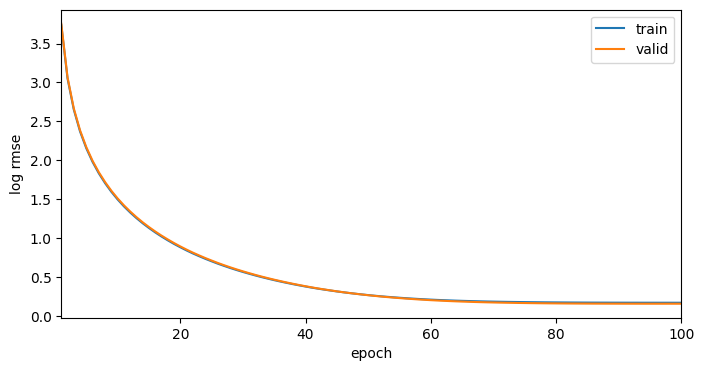

fold 1, train log rmse 0.169608, valid log rmse 0.157045
fold 2, train log rmse 0.162309, valid log rmse 0.190537
fold 3, train log rmse 0.163891, valid log rmse 0.168541
fold 4, train log rmse 0.167537, valid log rmse 0.154283
fold 5, train log rmse 0.162880, valid log rmse 0.182926
5-折验证：平均训练logrmse：0.165245,平均验证logrmse：0.170666


In [12]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs,
                          lr,weight_decay, batch_size) 

print(f"{k}-折验证：平均训练logrmse：{float(train_l):f},"
      f"平均验证logrmse：{float(valid_l):f}")

### 提交kaggle房价预测

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    
    print(f'train log rmse {float(train_ls[-1]) :f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape (1, - 1) [0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
train_and_pred(train_features, test_features, train_labels, test_df,num_epochs, lr, weight_decay, batch_size)

train log rmse 0.162381
